# **Detectron2 Object Detection Workflow**

**Detectron2 Documentation**
- https://detectron2.readthedocs.io/en/latest/index.html
- https://github.com/facebookresearch/detectron2


**Model Zoo**

There are many available pretrained models.
- https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

#### Detectron Installation

    !python -m pip install pyyaml==5.1
    import sys, os, distutils.core

    !git clone 'https://github.com/facebookresearch/detectron2'
    dist = distutils.core.run_setup("./detectron2/setup.py")
    !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
    sys.path.insert(0, os.path.abspath('./detectron2'))

### Packages

In [1]:
import os
import json
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Detectron2
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

### Data

**Annotations in COCO 1.0 Format**
- 50 images for train set
- 20 images for test set (Updating)

In [2]:
# Check Directory
print(os.path.exists('coco/instances_default_train.json'))
print(os.path.exists('coco/instances_default_test.json'))
print(os.path.exists('../split'))

True
True
True


In [3]:
# Register Data for Building Detection
register_coco_instances('hp_train', {}, 'coco/instances_default_train.json', '../split')
#register_coco_instances('hp_test', {}, 'instances_default_test.json', 'nbs/') # Not using it for now

# Validate data
dataset_metadata = MetadataCatalog.get('hp_train')
dataset_dicts = DatasetCatalog.get("hp_train")
#dataset_metadata = MetadataCatalog.get('hp_test')
#dataset_dicts = DatasetCatalog.get("hp_test")

In [12]:
# Remove registered data
# MetadataCatalog.remove('hp_train')
# DatasetCatalog.remove('hp_train')

In [5]:
train_json = open('coco/instances_default_train.json')
train_json = json.load(train_json)
#test_json = open('instances_default_test.json')
#test_json = json.load(test_json)

#### Sample Images

In [7]:
train_json['annotations'][1:4]

[{'id': 2,
  'image_id': 1,
  'category_id': 1,
  'segmentation': [],
  'area': 191767.0152,
  'bbox': [560.15, 274.63, 354.16, 541.47],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 3,
  'image_id': 2,
  'category_id': 1,
  'segmentation': [],
  'area': 85611.39129999999,
  'bbox': [0.0, 396.54, 258.59, 331.07],
  'iscrowd': 0,
  'attributes': {'occluded': True, 'rotation': 0.0}},
 {'id': 4,
  'image_id': 2,
  'category_id': 1,
  'segmentation': [],
  'area': 115366.92930000003,
  'bbox': [769.31, 0.03, 254.69, 452.97],
  'iscrowd': 0,
  'attributes': {'occluded': True, 'rotation': 0.0}}]

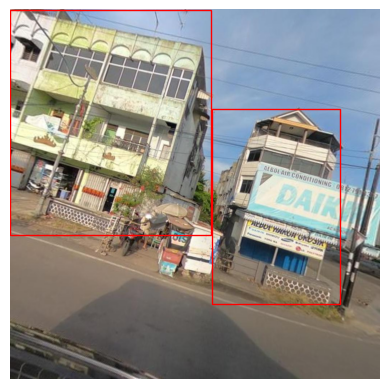

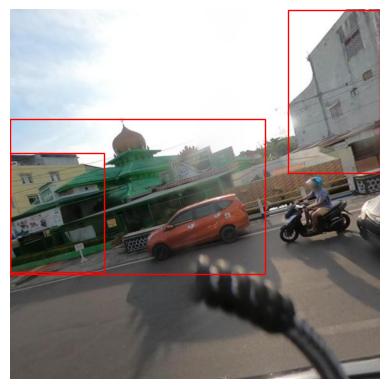

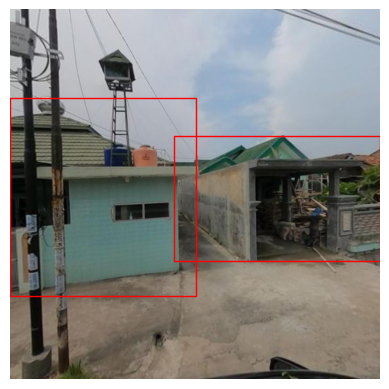

In [9]:
i = 0
for idx, im in enumerate(train_json['images']):
    if idx >= 3:
        break
    
    img = cv2.imread('../split/' + im['file_name'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert RGB Order
    
    fig, ax = plt.subplots()
    ax.imshow(img_rgb)
    
    for gt in train_json['annotations']:
        if gt['image_id'] == im['id']:
            rect = patches.Rectangle(
                (gt['bbox'][0], gt['bbox'][1]),
                gt['bbox'][2],
                gt['bbox'][3],
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            i += 1

    plt.axis('off')
    plt.show()

### Model Configuration

In [10]:
# Model config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))  # Faster R-CNN Model
cfg.DATASETS.TRAIN = ('hp_train',) # Train Dataset
cfg.DATASETS.TEST = ()  # Test Dataset Not Using Temporarily
cfg.DATALOADER.NUM_WORKERS = 2  # CPU Thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Weights from Model Zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch Size
cfg.SOLVER.BASE_LR = 0.00025  # Learning Rate
cfg.SOLVER.MAX_ITER = 1000  # Maximum Iteration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Num of Classes

### Model Training

In [11]:
# Train
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)  # Make Output Directory
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/04 21:03:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[10/04 21:03:21 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/04 21:03:34 d2.utils.events]:  eta: 0:06:12  iter: 19  total_loss: 1.266  loss_cls: 0.8374  loss_box_reg: 0.1968  loss_rpn_cls: 0.1844  loss_rpn_loc: 0.02194    time: 0.3808  last_time: 0.3522  data_time: 0.2132  last_data_time: 0.0009   lr: 4.9953e-06  max_mem: 1736M
[10/04 21:03:52 d2.utils.events]:  eta: 0:05:54  iter: 39  total_loss: 1.183  loss_cls: 0.747  loss_box_reg: 0.1969  loss_rpn_cls: 0.1713  loss_rpn_loc: 0.02253    time: 0.3714  last_time: 0.3834  data_time: 0.0012  last_data_time: 0.0012   lr: 9.9902e-06  max_mem: 1736M
[10/04 21:03:59 d2.utils.events]:  eta: 0:05:42  iter: 59  total_loss: 1.082  loss_cls: 0.5998  loss_box_reg: 0.2923  loss_rpn_cls: 0.1547  loss_rpn_loc: 0.02214    time: 0.3619  last_time: 0.3682  data_time: 0.0011  last_data_time: 0.0019   lr: 1.4985e-05  max_mem: 1736M
[10/04 21:04:07 d2.utils.events]:  eta: 0:05:39  iter: 79  total_loss: 1.171  loss_cls: 0.4941  loss_box_reg: 0.437  loss_rpn_cls: 0.1284  loss_rpn_loc: 0.02089    time: 0.3663  last

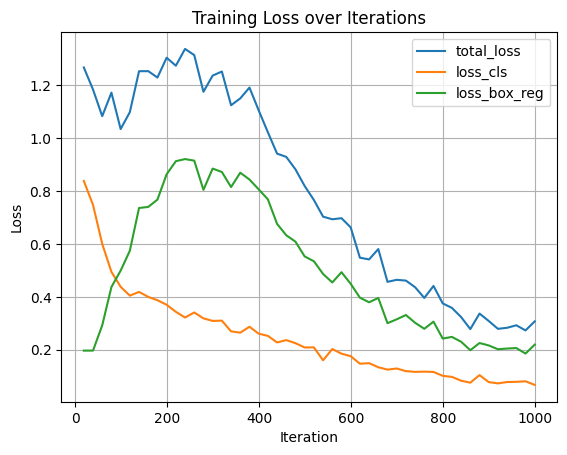

In [26]:
metrics_path = "output/metrics.json"

total_loss_values = []
cls_loss_values = []
box_reg_loss_values = []
iterations = []

with open(metrics_path, "r") as f:
    for line in f:
        data = json.loads(line)
        if "total_loss" in data: 
            iterations.append(data["iteration"])
            total_loss_values.append(data["total_loss"])
            cls_loss_values.append(data.get("loss_cls", 0))
            box_reg_loss_values.append(data.get("loss_box_reg", 0))

plt.plot(iterations, total_loss_values, label="total_loss")
plt.plot(iterations, cls_loss_values, label="loss_cls")
plt.plot(iterations, box_reg_loss_values, label="loss_box_reg")

plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### Predictions

In [17]:
# Load model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Learned Model Weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Prediction Threshold
predictor = DefaultPredictor(cfg)

[10/04 21:31:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, m

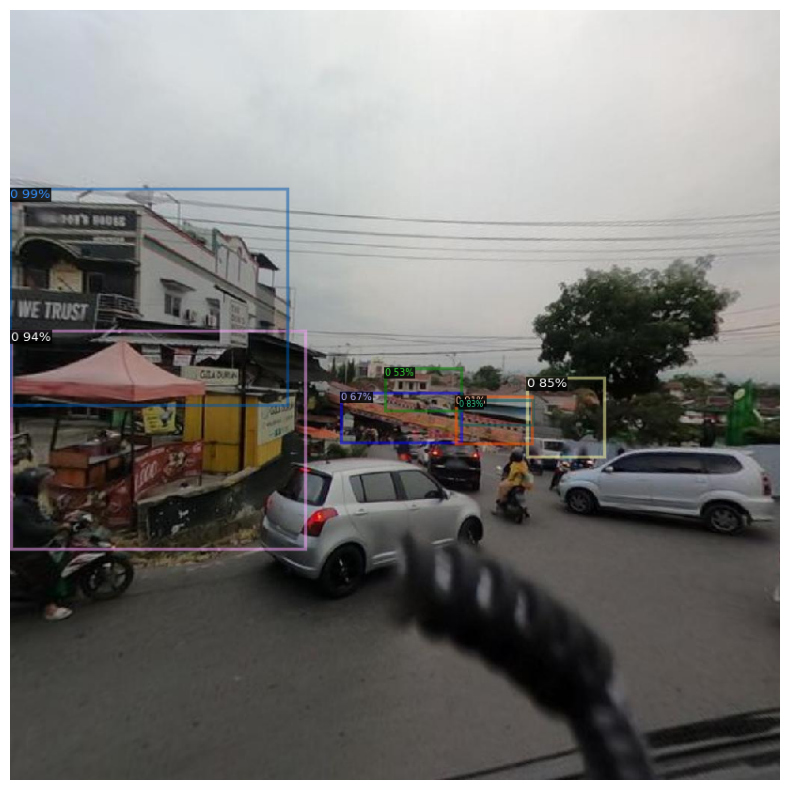

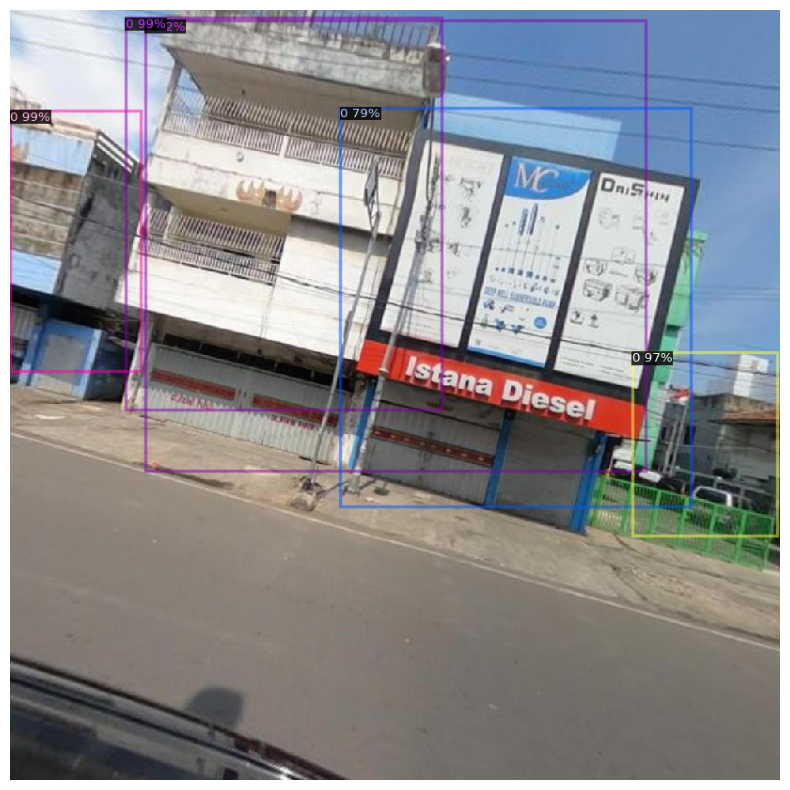

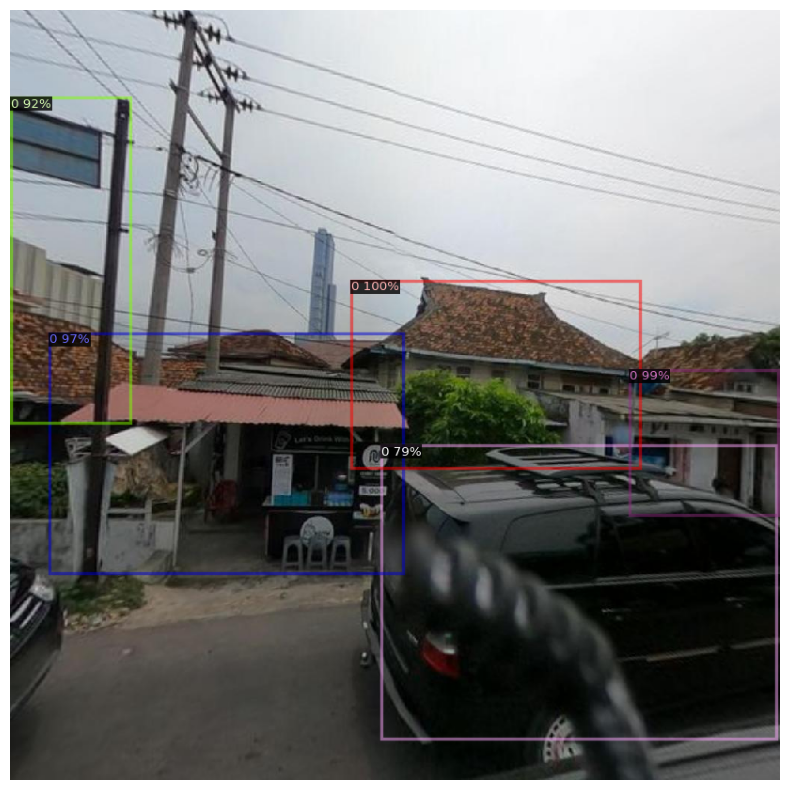

In [28]:
# Sample Images
img_paths = [
    '../split/813425686579401_right.jpg',
    '../split/814628423212932_left.jpg',
    '../split/823664802031496_right.jpg'
]

for path in img_paths:

    im = cv2.imread(path)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # Convert RGB

    # Predict
    outputs = predictor(im)
    v = Visualizer(im_rgb[:, :, ::-1], metadata=MetadataCatalog.get("my_dataset_train"), scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    output_image = out.get_image()[:, :, ::-1]

    plt.figure(figsize=(10, 10))
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()